# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import seaborn as sns
import filecmp
from sklearn.preprocessing import MaxAbsScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import warnings
from sklearn.neighbors import KNeighborsClassifier
import pydot
from IPython.display import Image
from mlxtend import plotting
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

## Global Variables

In [2]:
PBAR_FORMAT='{desc:12}{percentage:3.0f}%|{bar:27}[ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAP = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}

ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "eating chips", "eating pasta", "drinking from cup", "eating sandwich",
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball",
                  "writing", "clapping", "folding clothes"]

# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345

## Extracted Features

In [3]:
EXTRACTED_FEATURES = ['ACTIVITY',
                        'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
                        'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9',
                        'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9',
                        'XAVG', 'YAVG', 'ZAVG',
                        'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
                        'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV',
                        'XVAR', 'YVAR', 'ZVAR',
                        'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
                        'XMFCC5', 'XMFCC6', 'XMFCC7',
                        'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12',
                        'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4',
                        'YMFCC5', 'YMFCC6', 'YMFCC7',
                        'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
                        'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4',
                        'ZMFCC5', 'ZMFCC6', 'ZMFCC7',
                        'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12',
                        'XYCOS', 'XZCOS', 'YZCOS',
                        'XYCOR', 'XZCOR', 'YZCOR',
                        'RESULTANT',
                        'PARTICIPANT'] # Categirical: 1600 -1650

len(EXTRACTED_FEATURES)


90

## Dataset

In [4]:
def WISDM_Dataset(DATA_DIR):
    all_files = glob.glob(DATA_DIR + "/*.txt")

    list_dfs = []
    for filename in all_files:
        df = pd.read_csv(filename, names = EXTRACTED_FEATURES, index_col=None, header=0)
        list_dfs.append(df)

    all_data = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return all_data


## Training on Phone - Accelerometer

### Hyper parameters

In [5]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

param_grid = {'n_neighbors': [3, 5, 10, 20], 'leaf_size': [10, 20, 30, 40]}
DATA_DIR="../dataset/processed/phone/accel"

### Initialize Dataset

In [6]:
all_phone_accel = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_phone_accel.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_phone_accel.ACTIVITY
X = all_phone_accel.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [7]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [8]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)


knn_classifier = KNeighborsClassifier()
knn_model_gs = GridSearchCV(estimator=knn_classifier,
                        param_grid=param_grid,
                        cv=my_cv,
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 10, 'n_neighbors': 3}
{'mean_fit_time': array([0.01394391, 0.01326308, 0.0132658 , 0.01337371, 0.01343508,
       0.01330118, 0.01334834, 0.01331916, 0.01334376, 0.01325312,
       0.01342683, 0.01321478, 0.01330104, 0.01317439, 0.01329618,
       0.01363468]), 'std_fit_time': array([1.17620648e-03, 6.06441640e-05, 5.65821892e-05, 2.03767565e-04,
       1.74547699e-04, 1.48651520e-04, 1.93240575e-04, 1.28444973e-04,
       1.98343361e-04, 6.25085320e-05, 1.44189628e-04, 8.23895961e-05,
       8.50105307e-05, 5.17632158e-05, 9.95190565e-05, 3.47363384e-04]), 'mean_score_time': array([0.10593309, 0.09408026, 0.09914851, 0.1058486 , 0.09838653,
       0.09410229, 0.10369191, 0.10373807, 0.10599346, 0.09385619,
       0.09899035, 0.10306783, 0.09368482, 0.09446793, 0.09840775,
       0.11386795]), 'std_score_time': array([0.02516176, 0.00109457, 0.00327175, 0.003694  , 0.00793463,
       0.00071098, 0.00486062, 0.0008562 , 0.02480991, 0.00081029,
       0.00266861, 0.00150439

### Evaluation

#### Train Accuracy

In [9]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:",100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.5535307517084282, 0.5453302961275627, 0.558997722095672, 0.5444191343963554, 0.5498861047835991]


######################################################################################
train accuracy: 77.02961275626423
######################################################################################


#### Confusion Matrix

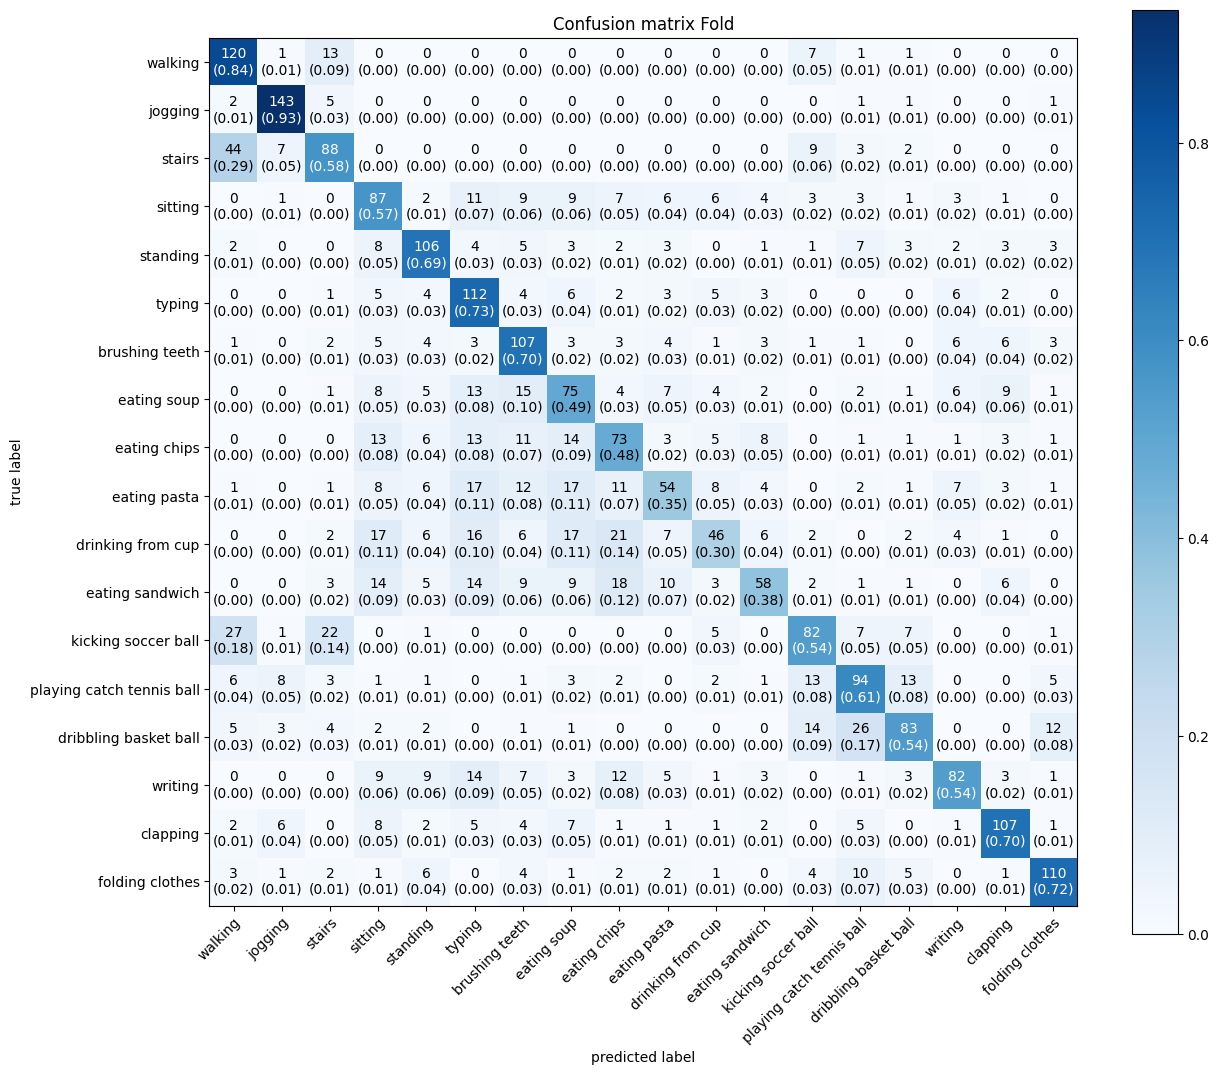

In [10]:
y_test_pred = knn_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [11]:
cm_act = pd.DataFrame(conf_matrix,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.839161
jogging                    0.934641
stairs                     0.575163
sitting                    0.568627
standing                   0.692810
typing                     0.732026
brushing teeth             0.699346
eating soup                0.490196
eating chips               0.477124
eating pasta               0.352941
drinking from cup          0.300654
eating sandwich            0.379085
kicking soccer ball        0.535948
playing catch tennis ball  0.614379
dribbling basket ball      0.542484
writing                    0.535948
clapping                   0.699346
folding clothes            0.718954


/tmp/ipykernel_2399269/1352430059.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [12]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.56      0.84      0.67       143
           B       0.84      0.93      0.88       153
           C       0.60      0.58      0.59       153
           D       0.47      0.57      0.51       153
           E       0.64      0.69      0.67       153
           F       0.50      0.73      0.60       153
           G       0.55      0.70      0.61       153
           H       0.45      0.49      0.47       153
           I       0.46      0.48      0.47       153
           J       0.51      0.35      0.42       153
           K       0.52      0.30      0.38       153
           L       0.61      0.38      0.47       153
           M       0.59      0.54      0.56       153
           O       0.57      0.61      0.59       153
           P       0.66      0.54      0.60       153
           Q       0.69      0.54      0.61       153
           R       0.74      0.70      0.72       153
           S       0.79    

#### Test Accuracy

In [13]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 59.2930029154519


## Training on Phone - Gyroscope

### Hyper parameters

In [14]:
NUM_SPLITS=5
TRAIN_SIZE=0.8
TEST_SIZE=1-TRAIN_SIZE

param_grid = {'n_neighbors': [3, 5, 10, 20], 'leaf_size': [10, 20, 30, 40]}
DATA_DIR="../dataset/processed/phone/gyro"

### Initialize Dataset

In [15]:
all_phone_gyro = WISDM_Dataset(DATA_DIR)

# The approach in this analysis will be to see all the participants as a single, unified group.
# The aim of this analysis is not to examine differences between participants.
all_phone_gyro.drop('PARTICIPANT', axis = 1, inplace = True)

y = all_phone_gyro.ACTIVITY
X = all_phone_gyro.drop('ACTIVITY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = TRAIN_SIZE,
                                                    test_size = TEST_SIZE,
                                                    shuffle = True,
                                                    stratify = y)

# Temporarily re-unite the train lables to train dataset for further preprocessing steps.
X_train.insert(0, 'Y', y_train)

# separating y_train
y_train = X_train['Y']
X_train.drop(['Y'], axis = 1, inplace = True)

# rescaling is applied to the features that their absolute values exceed the range of ~1
rescalin_features=['XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'RESULTANT']
scaling_transformer = MaxAbsScaler().fit(X_train[rescalin_features])
X_train[rescalin_features] = scaling_transformer.transform(X_train[rescalin_features])

X_test = X_test.copy()
X_test[rescalin_features] = scaling_transformer.transform(X_test[rescalin_features])

# resetting the indices
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [16]:
X_train.columns

Index(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1',
       'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3',
       'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XABSOLDEV',
       'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR',
       'YVAR', 'ZVAR', 'XMFCC0', 'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4',
       'XMFCC5', 'XMFCC6', 'XMFCC7', 'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11',
       'XMFCC12', 'YMFCC0', 'YMFCC1', 'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5',
       'YMFCC6', 'YMFCC7', 'YMFCC8', 'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12',
       'ZMFCC0', 'ZMFCC1', 'ZMFCC2', 'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6',
       'ZMFCC7', 'ZMFCC8', 'ZMFCC9', 'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS',
       'XZCOS', 'YZCOS', 'XYCOR', 'XZCOR', 'YZCOR', 'RESULTANT'],
      dtype='object')

### Training

In [17]:
my_cv = StratifiedShuffleSplit(n_splits=NUM_SPLITS,
                               train_size=TRAIN_SIZE,
                               test_size=TEST_SIZE)

knn_classifier = KNeighborsClassifier()
knn_model_gs = GridSearchCV(estimator=knn_classifier,
                        param_grid=param_grid,
                        cv=my_cv,
                        scoring='accuracy',
                        verbose = 0,
                        return_train_score = True)
knn_model_gs.fit(X_train, y_train)
knn_best_classifier = knn_model_gs.best_estimator_
print(knn_model_gs.best_params_)
print(knn_model_gs.cv_results_)
print(knn_best_classifier.get_params())

{'leaf_size': 10, 'n_neighbors': 5}
{'mean_fit_time': array([0.01338363, 0.01327314, 0.01334882, 0.01304989, 0.0131968 ,
       0.01317196, 0.0131721 , 0.01310282, 0.01314778, 0.01321039,
       0.01317902, 0.01312218, 0.01319785, 0.01320329, 0.01312771,
       0.01313066]), 'std_fit_time': array([2.33476779e-04, 1.29821541e-04, 9.85925833e-05, 1.21286172e-04,
       7.58387877e-05, 6.88744027e-05, 8.03378493e-05, 5.57798393e-05,
       3.84309451e-05, 1.00224501e-04, 1.23402416e-04, 1.04769230e-04,
       9.28201713e-05, 1.82952208e-04, 6.86974248e-05, 1.35430819e-04]), 'mean_score_time': array([0.09526334, 0.09435959, 0.0997273 , 0.10371566, 0.09497304,
       0.09429808, 0.09827409, 0.10492954, 0.09381223, 0.09491763,
       0.09837904, 0.1044106 , 0.09317155, 0.09527159, 0.09915409,
       0.10258956]), 'std_score_time': array([0.00423953, 0.00102469, 0.00267621, 0.00110094, 0.00284311,
       0.00087605, 0.00156819, 0.00097253, 0.00084933, 0.0016546 ,
       0.00094558, 0.00129025

### Evaluation

#### Train Accuracy

In [18]:
scores = cross_val_score(knn_best_classifier, X_train, y_train, cv=my_cv, scoring='accuracy')
print(list(scores))

knn_best_classifier.score(X_train, y_train)
y_train_pred = knn_best_classifier.predict(X_train)

print("######################################################################################")
print("train accuracy:", 100 * accuracy_score(y_true=y_train, y_pred=y_train_pred))
print("######################################################################################")

[0.3990888382687927, 0.4068337129840547, 0.40455580865603646, 0.3968109339407745, 0.40728929384965834]


######################################################################################
train accuracy: 61.594533029612755
######################################################################################


#### Confusion Matrix

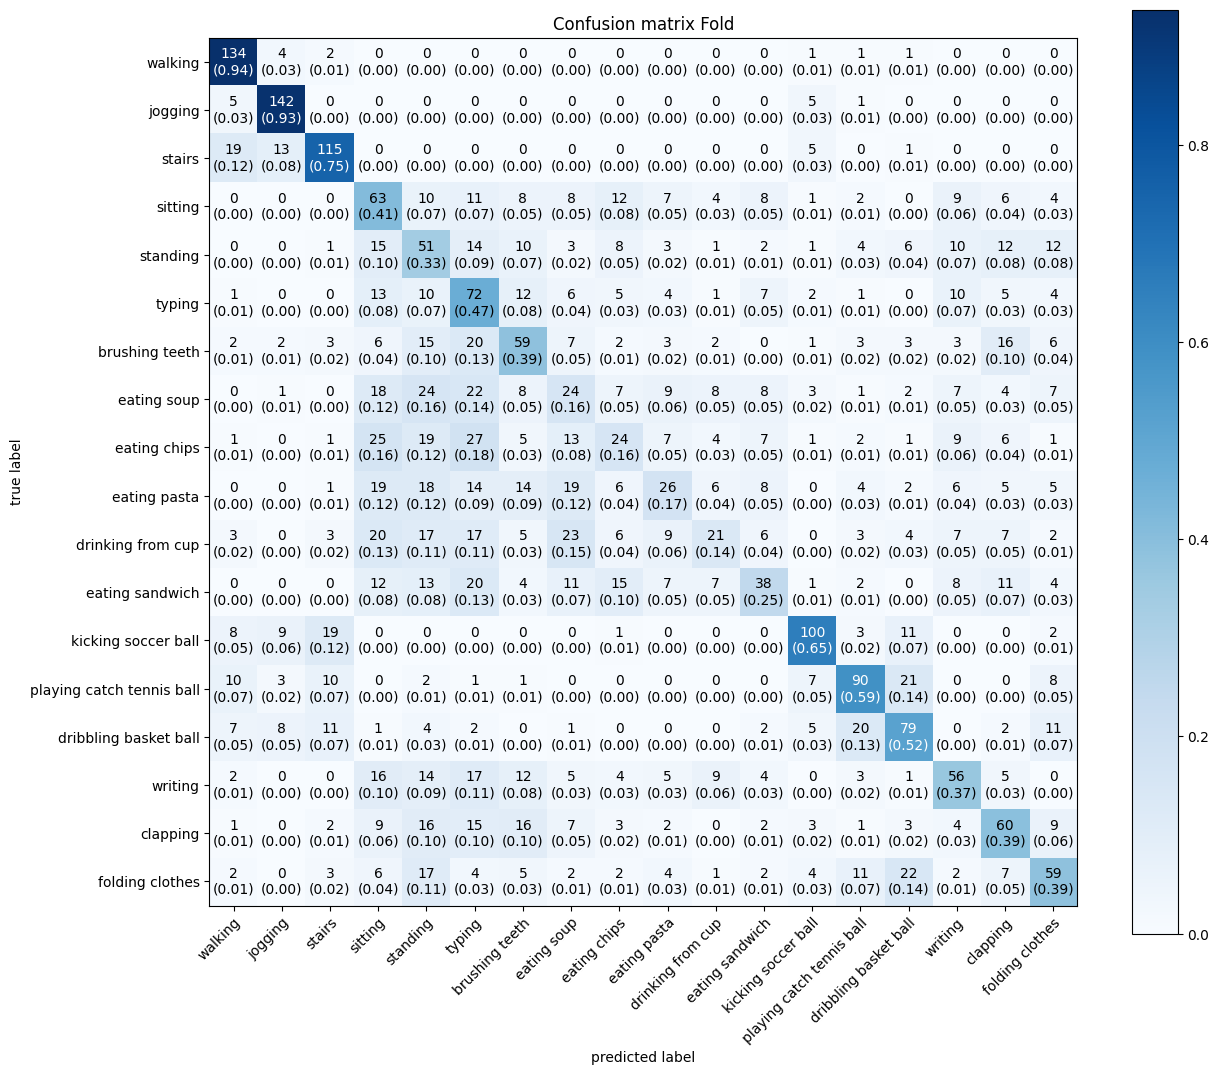

In [19]:
y_test_pred = knn_best_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                               class_names = ACTIVITY_NAMES,
                               show_normed = True,
                               figsize = (14, 12),
                               colorbar = True)
plt.title("Confusion matrix Fold")
plt.show()

#### Accuracy Per Activity

In [20]:
cm_act = pd.DataFrame(conf_matrix,
                      index=knn_best_classifier.classes_,
                      columns=knn_best_classifier.classes_)

cm_act.columns = ACTIVITY_CODES_MAP.values()
cm_act.index = ACTIVITY_CODES_MAP.values()
accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())
print(accuracy_per_activity)

                                  0
walking                    0.937063
jogging                    0.928105
stairs                     0.751634
sitting                    0.411765
standing                   0.333333
typing                     0.470588
brushing teeth             0.385621
eating soup                0.156863
eating chips               0.156863
eating pasta               0.169935
drinking from cup          0.137255
eating sandwich            0.248366
kicking soccer ball        0.653595
playing catch tennis ball  0.588235
dribbling basket ball      0.516340
writing                    0.366013
clapping                   0.392157
folding clothes            0.385621


/tmp/ipykernel_2399269/1352430059.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  accuracy_per_activity = pd.DataFrame([cm_act.iloc[i][i]/np.sum(cm_act.iloc[i]) for i in range(18)],index=ACTIVITY_CODES_MAP.values())


#### Classification Report

In [21]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_pred))
print("######################################################################################")

              precision    recall  f1-score   support

           A       0.69      0.94      0.79       143
           B       0.78      0.93      0.85       153
           C       0.67      0.75      0.71       153
           D       0.28      0.41      0.34       153
           E       0.22      0.33      0.27       153
           F       0.28      0.47      0.35       153
           G       0.37      0.39      0.38       153
           H       0.19      0.16      0.17       153
           I       0.25      0.16      0.19       153
           J       0.30      0.17      0.22       153
           K       0.33      0.14      0.19       153
           L       0.40      0.25      0.31       153
           M       0.71      0.65      0.68       153
           O       0.59      0.59      0.59       153
           P       0.50      0.52      0.51       153
           Q       0.43      0.37      0.39       153
           R       0.41      0.39      0.40       153
           S       0.44    

#### Test Accuracy

In [22]:
print("test accuracy", 100 * accuracy_score(y_true=y_test, y_pred=y_test_pred))

test accuracy 44.20553935860058
